In [1]:
# %%
import json, os, re, math, statistics
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

NOTEBOOK_DIR = Path.cwd()

EVAL_PATH = NOTEBOOK_DIR.parent / "eval_train_scored.json"
RAW_PATH = NOTEBOOK_DIR.parent / "eval_train_raw.json"

with open(EVAL_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# If file is a dict with a "results" field, normalize:
if isinstance(data, dict) and "results" in data:
    data = data["results"]

print(f"Loaded {len(data)} rows")
# Peek first row keys to understand schema
print("Keys in first row:", sorted(list(data[0].keys())))



Loaded 118 rows
Keys in first row: ['answer_jaccard', 'filename_match', 'gt_answer', 'gt_filename', 'gt_page', 'idx', 'page_match', 'pr_answer', 'pr_filename', 'pr_page', 'question', 'score']


In [2]:
def normalize_filename(name: str) -> str:
    if not name: return ""
    base = os.path.basename(str(name))
    base = base.replace("（","(").replace("）",")").replace("，",",").replace("：",":")
    base = re.sub(r"\s+", "", base)
    base = re.sub(r"(\d+)页(?=\.pdf$)", "", base, flags=re.I)  # drop trailing "...NN页" before .pdf
    return base.lower()

def tokenize_zh_en(s: str):
    s = (s or "").strip()
    return re.findall(r"[\u4e00-\u9fff]|[A-Za-z0-9]+", s)

def jaccard(a: str, b: str) -> float:
    A, B = set(tokenize_zh_en(a)), set(tokenize_zh_en(b))
    if not A and not B: return 1.0
    if not A or not B: return 0.0
    return len(A & B) / len(A | B)

# ---- Load scored (grounded evaluation) ----
with open(EVAL_PATH, "r", encoding="utf-8") as f:
    eval_rows = json.load(f)
print("Scored rows:", len(eval_rows))
print("Scored keys example:", sorted(eval_rows[0].keys()))

eval_df = pd.DataFrame(eval_rows)

# ---- Load raw (with telemetry/debug, retrieval_chunks) ----
with open(RAW_PATH, "r", encoding="utf-8") as f:
    raw_rows = json.load(f)
print("Raw pairs:", len(raw_rows))
# raw is [[idx, {...}], ...]
raw_df = pd.DataFrame([{"idx": k, **v} for k, v in raw_rows])

# normalize file cols for later joins
for col in ["gt_filename","pr_filename","filename","model_file","top_file"]:
    if col in eval_df.columns:
        eval_df[col+"_norm"] = eval_df[col].map(normalize_filename)
for col in ["filename","debug"]:
    if col in raw_df.columns and col=="filename":
        raw_df[col+"_norm"] = raw_df[col].map(normalize_filename)

Scored rows: 118
Scored keys example: ['answer_jaccard', 'filename_match', 'gt_answer', 'gt_filename', 'gt_page', 'idx', 'page_match', 'pr_answer', 'pr_filename', 'pr_page', 'question', 'score']
Raw pairs: 118


In [3]:
# %%
def acc_exact(pred, gt):
    m = pred.notna() & gt.notna()
    return float((pred[m]==gt[m]).mean())

summary = {
    "N"                 : len(eval_df),
    "Mean score"        : float(eval_df["score"].mean()),
    "Mean Jaccard"      : float(eval_df["answer_jaccard"].mean()),
    "Filename exact@1"  : float(eval_df["filename_match"].mean()),
    "Page exact@1"      : float(eval_df["page_match"].mean()),
}
pd.Series(summary)


N                   118.000000
Mean score            0.384071
Mean Jaccard          0.302040
Filename exact@1      0.533898
Page exact@1          0.398305
dtype: float64

In [4]:
# Filename/page correctness vs answer quality
eval_df["bucket"] = np.select(
    [
        (eval_df["filename_match"]==1) & (eval_df["page_match"]==1),
        (eval_df["filename_match"]==1) & (eval_df["page_match"]==0),
        (eval_df["filename_match"]==0) & (eval_df["page_match"]==1),
    ],
    ["Both-correct","File-OK/Page-Wrong","File-Wrong/Page-OK"],
    default="Both-wrong"
)
eval_df["bucket"].value_counts(), eval_df.groupby("bucket")[["score","answer_jaccard"]].mean()


(bucket
 Both-wrong            55
 Both-correct          47
 File-OK/Page-Wrong    16
 Name: count, dtype: int64,
                        score  answer_jaccard
 bucket                                      
 Both-correct        0.675619        0.351238
 Both-wrong          0.131978        0.263956
 File-OK/Page-Wrong  0.394218        0.288436)

### Page Wrong 

In [11]:
mask = (eval_df["filename_match"]==1) & (eval_df["page_match"]==0)
def _off1(r):
    try:
        return abs(int(r["pr_page"])-int(r["gt_page"]))==1
    except: return False
off1_ratio = float(mask.sum() and sum(_off1(r) for _,r in eval_df[mask].iterrows())/mask.sum())
off1_ratio


0.25

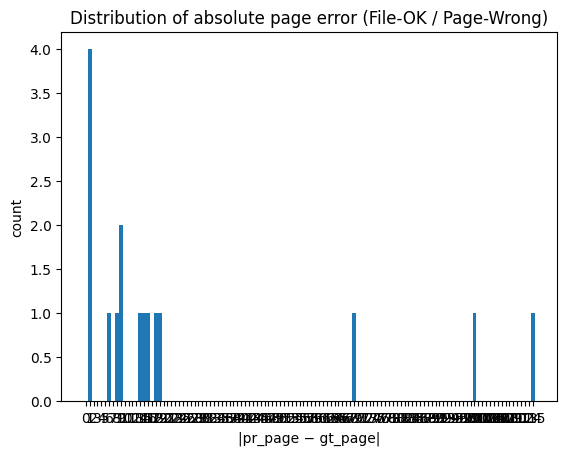

counts (sorted):
1      4
6      1
8      1
9      2
14     1
15     1
16     1
18     1
19     1
69     1
100    1
115    1
Name: count, dtype: int64
N=16, mean=25.12, median=11.5, p90=84.5


In [12]:
# 取子集：文件对但页错
sub = eval_df[(eval_df["filename_match"]==1) & (eval_df["page_match"]==0)].copy()

# 安全转 int
def _to_int(x):
    try:
        return int(x)
    except:
        return np.nan

sub["pr_page_int"] = sub["pr_page"].apply(_to_int)
sub["gt_page_int"] = sub["gt_page"].apply(_to_int)
sub = sub.dropna(subset=["pr_page_int","gt_page_int"])

# 绝对页差
diff = (sub["pr_page_int"] - sub["gt_page_int"]).abs()

# 用 1 页为宽度的整数 bin；至少展示到 6 页
max_diff = int(np.nanmax(diff)) if len(diff) else 0
bins = np.arange(-0.5, max(6, max_diff) + 1.5, 1)

plt.figure()
plt.hist(diff, bins=bins)
plt.xticks(range(0, int(bins[-1]) + 1))
plt.xlabel("|pr_page − gt_page|")
plt.ylabel("count")
plt.title("Distribution of absolute page error (File-OK / Page-Wrong)")
plt.show()

# 分布与概览
print("counts (sorted):")
print(diff.value_counts().sort_index())
if len(diff):
    print(f"N={len(diff)}, mean={diff.mean():.2f}, median={diff.median():.1f}, p90={diff.quantile(0.90):.1f}")

## File Wrong

In [16]:
# %% Both-wrong 深度拆解（召回 vs 排序/投票）
import re, os, json
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
from collections import Counter

# --- 小工具（与前面重复也无妨） ---
def canonicalize_filename(fn: str):
    x = (fn or "")
    x = re.sub(r'[-_（(]?\d{6,8}[)）]?页?', '', x)                 # 页数字串
    x = re.sub(r'[-_（(]?(19|20)\d{2}[\d\-_.]*[)）]?', '', x)     # 年月日
    x = re.sub(r'\.pdf$', '', x, flags=re.I)
    x = re.sub(r'\s+', '', x)
    return x

COMPANY_TOKEN_RE = re.compile(r'([一-龥A-Za-z0-9]+)')
def company_tokens_from_filename(fn: str):
    core = canonicalize_filename(fn)
    toks = [t for t in COMPANY_TOKEN_RE.findall(core) if len(t)>=2]
    return set(toks)

def same_company_heur(pr_fn, gt_fn):
    a, b = canonicalize_filename(pr_fn), canonicalize_filename(gt_fn)
    ratio = SequenceMatcher(None, a, b).ratio()
    ia, ib = company_tokens_from_filename(pr_fn), company_tokens_from_filename(gt_fn)
    overlap = len(ia & ib)
    return (ratio >= 0.65 or overlap >= 3), ratio, overlap

def get_top_rr_from_row(row):
    # 优先 debug.top_rr；其次 retrieval_chunks[0].rerank_score；否则 NaN
    dbg = row.get("debug", {}) if isinstance(row.get("debug", {}), dict) else {}
    if "top_rr" in dbg and dbg["top_rr"] is not None:
        try: return float(dbg["top_rr"])
        except: pass
    ch = row.get("retrieval_chunks") or []
    if isinstance(ch, list) and ch:
        rr = ch[0].get("rerank_score")
        if rr is not None:
            try: return float(rr)
            except: pass
    return np.nan

# --- 准备 Both-wrong 数据 ---
bw = eval_df[(eval_df["filename_match"]==0) & (eval_df["page_match"]==0)].copy()
# raw_df: 形如 [{"idx":..., "question":..., "retrieval_chunks":[...], "debug":{...}}]
bw = bw.merge(raw_df[["idx","question","filename","retrieval_chunks","debug"]], on="idx", how="left")

for col in ["pr_filename","gt_filename","filename"]:
    bw[col+"_norm"] = bw[col].map(normalize_filename)

# --- 召回可见性度量 ---
def cand_files_norm(row):
    ch = row.get("retrieval_chunks") or []
    files = []
    for c in ch:
        fn = (((c.get("metadata") or {}).get("file_name")) or "")
        files.append(normalize_filename(fn))
    return set(files)

def cand_pages_for_gt(row):
    ch = row.get("retrieval_chunks") or []
    gt = row.get("gt_filename_norm","")
    pages = []
    for c in ch:
        md = c.get("metadata") or {}
        if normalize_filename(md.get("file_name","")) == gt:
            try:
                pages.append(int(md.get("page")))
            except:
                pass
    return set(pages)

def safe_list(d, key):
    v = (d or {}).get("debug", {})
    arr = v.get(key, [])
    return arr if isinstance(arr, list) else []

bw["cand_files_norm"]    = bw.apply(cand_files_norm, axis=1)
bw["gt_in_candidates"]   = bw.apply(lambda r: r["gt_filename_norm"] in r["cand_files_norm"], axis=1)
bw["gt_pages_in_cands"]  = bw.apply(cand_pages_for_gt, axis=1)
bw["gt_page_in_cands"]   = bw.apply(lambda r: (isinstance(r.get("gt_page"), (int, np.integer, float, str))
                                               and str(r["gt_page"]).isdigit()
                                               and int(r["gt_page"]) in r["gt_pages_in_cands"]), axis=1)

# RRF/BM25 可见性（若有 debug 字段）
def list_norm(arr): return [normalize_filename(x) for x in arr if isinstance(x, str)]
bw["bm25_top_files"]     = bw.apply(lambda r: list_norm((r.get("debug") or {}).get("bm25_top_files",[]) ), axis=1)
bw["rrf_top3_files"]     = bw.apply(lambda r: list_norm((r.get("debug") or {}).get("first3_files_after_rrf",[]) ), axis=1)
bw["gt_in_bm25_top5"]    = bw.apply(lambda r: r["gt_filename_norm"] in (r["bm25_top_files"][:5] if isinstance(r["bm25_top_files"], list) else []), axis=1)
bw["gt_in_rrf_top3"]     = bw.apply(lambda r: r["gt_filename_norm"] in (r["rrf_top3_files"][:3] if isinstance(r["rrf_top3_files"], list) else []), axis=1)

# --- 失败阶段粗分类（仅用于诊断，不代表解决方案） ---
def fail_stage(row):
    if not row["gt_in_candidates"]:
        return "Recall-miss(FILE)"    # 召回阶段连正确文件都没进池
    if row["gt_in_candidates"] and not row["gt_page_in_cands"]:
        return "Recall-miss(PAGE)"    # 文件进池了，但正确页没被召回
    return "Rank/Vote-miss"           # 文件+正确页都在池中，但最终没选中

bw["fail_stage"] = bw.apply(fail_stage, axis=1)

# --- 同公司/跨公司 线索（基于文件名启发式） ---
def reason_label(row):
    pr, gt = row["pr_filename"], row["gt_filename"]
    same_series, ratio, overlap = same_company_heur(pr, gt)
    if same_series:
        # 判断年份是否不一致
        pr_years = set(re.findall(r'20\d{2}', pr or ""))
        gt_years = set(re.findall(r'20\d{2}', gt or ""))
        if pr_years and gt_years and pr_years != gt_years:
            return "Same-series (year mismatch)"
        return "Same-series (other)"
    else:
        # 粗略区分“跨公司误配”
        return "Cross-company confusion"

bw["reason"] = bw.apply(reason_label, axis=1)

# --- 置信度 ---
bw["top_rr"] = bw.apply(get_top_rr_from_row, axis=1)
bw["high_conf"] = bw["top_rr"] >= 0.90

# === 汇总输出（只观察，不建议） ===
print("Both-wrong N =", len(bw))
print("\n[失败阶段占比]")
print(bw["fail_stage"].value_counts(normalize=True).rename(lambda k: f"{k}").map(lambda x: f"{x:.1%}"))

print("\n[高置信错误占比 by 失败阶段]")
print(bw.groupby("fail_stage")["high_conf"].mean().fillna(0).map(lambda x: f"{x:.1%}"))

print("\n[GT 文件在 BM25 Top5 / RRF Top3 的可见性]")
vis = pd.Series({
    "gt_in_bm25_top5" : float(bw["gt_in_bm25_top5"].mean()),
    "gt_in_rrf_top3"  : float(bw["gt_in_rrf_top3"].mean()),
}).map(lambda x: f"{x:.1%}")
print(vis)

print("\n[跨/同公司 迹象]")
print(bw["reason"].value_counts(normalize=True).map(lambda x: f"{x:.1%}"))

# # 导出一个便于人工复盘的清单
# cols = ["idx","question","pr_filename","gt_filename","pr_page","gt_page",
#         "fail_stage","top_rr","high_conf","gt_in_bm25_top5","gt_in_rrf_top3","reason"]
# bw[cols].to_csv("both_wrong_review.csv", index=False, encoding="utf-8-sig")
# print("\nSaved: both_wrong_review.csv")


Both-wrong N = 55

[失败阶段占比]
fail_stage
Recall-miss(FILE)    98.2%
Recall-miss(PAGE)     1.8%
Name: proportion, dtype: object

[高置信错误占比 by 失败阶段]
fail_stage
Recall-miss(FILE)    85.2%
Recall-miss(PAGE)     0.0%
Name: high_conf, dtype: object

[GT 文件在 BM25 Top5 / RRF Top3 的可见性]
gt_in_bm25_top5    40.0%
gt_in_rrf_top3     36.4%
dtype: object

[跨/同公司 迹象]
reason
Cross-company confusion    100.0%
Name: proportion, dtype: object


In [18]:
# %% Both-wrong: 2x2 breakdown (BM25_top5 vs RRF_top3)
grid = (bw
        .assign(bm25_hit = bw["gt_in_bm25_top5"].astype(bool),
                rrf_hit  = bw["gt_in_rrf_top3"].astype(bool))
        .groupby(["bm25_hit","rrf_hit"])
        .size()
        .rename("count")
        .reset_index())

total = len(bw)
grid["pct"] = grid["count"] / (total if total else 1)

print("2x2 counts / proportions within Both-wrong:")
print(grid.sort_values(["bm25_hit","rrf_hit"])
          .assign(pct=lambda d: (d["pct"]*100).round(1).astype(str) + "%"))

# 可选：看各格子的 top_rr 分布（了解“自信错”的集中区）
try:
    tmp = bw.assign(bm25_hit=bw["gt_in_bm25_top5"].astype(bool),
                    rrf_hit=bw["gt_in_rrf_top3"].astype(bool))
    print("\nMedian top_rr by cell:")
    print(tmp.groupby(["bm25_hit","rrf_hit"])["top_rr"].median().round(3))
except Exception:
    pass

# # 可选：导出“看过但丢了”的样本，便于人工复核
# mask_seen_then_lost = (bw["gt_in_bm25_top5"] | bw["gt_in_rrf_top3"])
# cols = ["idx","question","pr_filename","gt_filename","pr_page","gt_page",
#         "bm25_top_files","rrf_top3_files","top_rr","reason","debug"]
# bw.loc[mask_seen_then_lost, cols]\
#   .to_csv("both_wrong_seen_then_lost.csv", index=False, encoding="utf-8-sig")
# print("\nSaved: both_wrong_seen_then_lost.csv")


2x2 counts / proportions within Both-wrong:
   bm25_hit  rrf_hit  count    pct
0     False    False     23  41.8%
1     False     True     10  18.2%
2      True    False     12  21.8%
3      True     True     10  18.2%

Median top_rr by cell:
bm25_hit  rrf_hit
False     False      0.992
          True       0.992
True      False      0.979
          True       0.989
Name: top_rr, dtype: float64


In [19]:
def rank_pos(lst, target):
    if not isinstance(lst, list): return np.nan
    try:
        return lst.index(target) + 1  # 1-based
    except ValueError:
        return np.nan

seen_then_lost = bw[(bw["gt_in_bm25_top5"]) | (bw["gt_in_rrf_top3"])].copy()
seen_then_lost["rrf_pos"] = seen_then_lost.apply(lambda r: rank_pos(r["rrf_top3_files"], r["gt_filename_norm"]), axis=1)
seen_then_lost["bm25_pos"] = seen_then_lost.apply(lambda r: rank_pos(r["bm25_top_files"], r["gt_filename_norm"]), axis=1)

# 只看 RRF 命中的那 3 桶（pos ∈ {1,2,3}）
rrf_hit = seen_then_lost[~seen_then_lost["rrf_pos"].isna()].copy()
print("RRF命中子集 N =", len(rrf_hit))
print("RRF rank 位置分布：")
print(rrf_hit["rrf_pos"].value_counts().sort_index())

# 交叉看 top_rr 置信度
print("\nRRF rank 位置 → top_rr 中位数：")
print(rrf_hit.groupby("rrf_pos")["top_rr"].median().round(3))

RRF命中子集 N = 20
RRF rank 位置分布：
rrf_pos
1.0    8
2.0    5
3.0    7
Name: count, dtype: int64

RRF rank 位置 → top_rr 中位数：
rrf_pos
1.0    0.989
2.0    0.990
3.0    0.992
Name: top_rr, dtype: float64


In [30]:

def _norm(s):
    s = os.path.basename(str(s or ""))
    s = s.replace("（","(").replace("）",")").replace("，",",").replace("：",":")
    s = re.sub(r"\s+","", s)
    s = re.sub(r"(\d+)页(?=\.pdf$)", "", s, flags=re.I)
    return s.lower()

bw_seen = bw[(bw["gt_in_bm25_top5"]) | (bw["gt_in_rrf_top3"])].copy()
bw_seen["gt_fn"] = bw_seen["gt_filename"].map(_norm)

# 取 debug 关键信号（缺就默认）
bw_seen["top_file"] = bw_seen["debug"].apply(lambda d: _norm((d or {}).get("top_file","")))
bw_seen["vote_n"]   = pd.to_numeric(bw_seen["debug"].apply(lambda d: (d or {}).get("file_vote_n", 0)),
                                    errors="coerce").fillna(0).astype(int)
bw_seen["vote_ran"] = bw_seen["vote_n"] > 0

def _rrf_pos(row):
    lst = (row.get("debug") or {}).get("first3_files_after_rrf", []) or []
    lst = [_norm(x) for x in lst if isinstance(x, str)]
    try: return lst.index(row["gt_fn"]) + 1
    except ValueError: return np.nan

bw_seen["rrf_pos"] = bw_seen.apply(_rrf_pos, axis=1)
rrf_hit = bw_seen[~bw_seen["rrf_pos"].isna()].copy()

print("RRF命中且最终丢失 N =", len(rrf_hit))
print("\n[投票是否运行]");           print(rrf_hit["vote_ran"].value_counts(dropna=False).rename({True:"ran",False:"not_ran"}))
print("\n[最终 top_file 是否 GT]");   print((rrf_hit["top_file"] == rrf_hit["gt_fn"]).value_counts(dropna=False))
print("\n[RRF pos 分布]");            print(rrf_hit["rrf_pos"].value_counts().sort_index())

# 预览（只显示存在的列）
preview_cols = [c for c in ["idx","question","gt_filename","top_file","vote_n","rrf_pos"] if c in rrf_hit.columns]
print("\n[RRF pos=1 子集预览]")
print(rrf_hit[rrf_hit["rrf_pos"]==1][preview_cols].head(10))


RRF命中且最终丢失 N = 20

[投票是否运行]
vote_ran
not_ran    20
Name: count, dtype: int64

[最终 top_file 是否 GT]
False    20
Name: count, dtype: int64

[RRF pos 分布]
rrf_pos
1.0    8
2.0    5
3.0    7
Name: count, dtype: int64

[RRF pos=1 子集预览]
    idx                               gt_filename  \
12   42  广联达-再谈广联达当前时点下如何看待其三条增长曲线-220217131页.pdf   
19  107         广联达-深度跟踪报告数字建筑一体化领军-21082339页.pdf   
23   39  广联达-再谈广联达当前时点下如何看待其三条增长曲线-220217131页.pdf   
31   86           千味央厨-厨之道央泱食材中有千味结-21090631页.pdf   
33  105         广联达-深度跟踪报告数字建筑一体化领军-21082339页.pdf   
43  115         广联达-深度跟踪报告数字建筑一体化领军-21082339页.pdf   
48  104         广联达-深度跟踪报告数字建筑一体化领军-21082339页.pdf   
53   93   千味央厨-兼具确定性与成长性的速冻面米制品B端龙头-22042629页.pdf   

                                  top_file  vote_n  rrf_pos  
12         广联达-公司深度报告数字建筑全生命周期解决方案领军者-.pdf       0      1.0  
19  广联达-数字经济saas专题广联达深度报告数字建筑领军战略驱动成长-.pdf       0      1.0  
23         广联达-公司深度报告数字建筑全生命周期解决方案领军者-.pdf       0      1.0  
31                 千味央厨-稳定成长兼具千味奋进正当时-.pdf   

In [31]:
# 1) RRF命中且最终丢失的样本里，最终候选池包含了多少“不同文件”？
#    如果大多是 1，说明在 RRF 后被裁剪到只剩一个（而且不是GT），所以 vote_n=0 就不奇怪了。
def _norm(s):
    import os, re
    s = os.path.basename(str(s or ""))
    s = re.sub(r"\s+","", s)
    s = re.sub(r"(\d+)页(?=\.pdf$)", "", s, flags=re.I)
    return s.lower()

def n_unique_files_in_pool(row):
    ch = row.get("retrieval_chunks") or []
    files = {_norm((c.get("metadata") or {}).get("file_name","")) for c in ch}
    return len(files)

rrf_hit["n_files_in_pool"] = rrf_hit.apply(n_unique_files_in_pool, axis=1)
print("不同文件个数分布：")
print(rrf_hit["n_files_in_pool"].value_counts().sort_index())
print("Only-1-file pool 占比：", float((rrf_hit["n_files_in_pool"]==1).mean()))


不同文件个数分布：
n_files_in_pool
1    19
4     1
Name: count, dtype: int64
Only-1-file pool 占比： 0.95


In [32]:
# 2) 这些“丢失样本”里，最终 top_file 和 GT 是否同公司（粗粒度启发式）
import re
def same_company_rough(a, b):
    ta = set(re.findall(r"[一-龥A-Za-z]{2,}", _norm(a)))
    tb = set(re.findall(r"[一-龥A-Za-z]{2,}", _norm(b)))
    overlap = ta & tb
    # 只要有中文词或较长英文片段重合，就算同公司/同系列
    return any(any('\u4e00' <= ch <= '\u9fff' for ch in tok) or len(tok)>=3 for tok in overlap)

rrf_hit["same_company"] = rrf_hit.apply(lambda r: same_company_rough(r.get("gt_filename",""), r.get("top_file","")), axis=1)
print("同公司/同系列？")
print(rrf_hit["same_company"].value_counts(dropna=False))

同公司/同系列？
same_company
True    20
Name: count, dtype: int64


In [ ]:
# %% 单文件池占比：各桶 & Both-wrong 的 2×2 分组
def _norm(s):
    s = os.path.basename(str(s or ""))
    s = re.sub(r"\s+","", s)
    s = re.sub(r"(\d+)页(?=\.pdf$)", "", s, flags=re.I)
    return s.lower()

def n_unique_files_in_pool(row):
    ch = row.get("retrieval_chunks") or []
    return len({_norm((c.get("metadata") or {}).get("file_name","")) for c in ch})

# 先把 raw 的检索池并回 eval
full = eval_df.merge(raw_df[["idx","retrieval_chunks"]], on="idx", how="left")
full["n_files_in_pool"] = full.apply(n_unique_files_in_pool, axis=1)
full["only_one_file"]   = (full["n_files_in_pool"] == 1)

# 1) 各桶对比
by_bucket = (full
    .groupby("bucket")["only_one_file"]
    .mean().rename("OnlyOneFile%")
    .to_frame()
    .assign(N = full.groupby("bucket").size()))
print("各桶：单文件池占比")
print( (by_bucket.assign(OnlyOneFilePct=(by_bucket["OnlyOneFile%"]*100).round(1).astype(str)+"%")
              .drop(columns=["OnlyOneFile%"])) )

# 2) Both-wrong 内按 2×2（BM25_hit × RRF_hit）
tmp = full[(full["filename_match"]==0) & (full["page_match"]==0)].copy()
# 需要这两列（若前面已算过可直接用）：
tmp = tmp.merge(raw_df[["idx","debug"]], on="idx", how="left")
def _norm_list(dkey):
    return lambda r: [_norm(x) for x in ((r.get("debug") or {}).get(dkey, []) or []) if isinstance(x,str)]
tmp["bm25_top_files"] = tmp.apply(_norm_list("bm25_top_files"), axis=1)
tmp["rrf_top3_files"] = tmp.apply(_norm_list("first3_files_after_rrf"), axis=1)
tmp["gt_fn"] = tmp["gt_filename"].map(_norm)

tmp["bm25_hit"] = tmp.apply(lambda r: r["gt_fn"] in r["bm25_top_files"][:5], axis=1)
tmp["rrf_hit"]  = tmp.apply(lambda r: r["gt_fn"] in r["rrf_top3_files"][:3], axis=1)

grid = (tmp
    .groupby(["bm25_hit","rrf_hit"])["only_one_file"]
    .agg(["mean","count"])
    .reset_index())
grid["OnlyOneFilePct"] = (grid["mean"]*100).round(1).astype(str)+"%"
grid = grid.drop(columns=["mean"]).rename(columns={"count":"N"})
print("\nBoth-wrong 的 2×2：单文件池占比")
print(grid.sort_values(["bm25_hit","rrf_hit"]))


各桶：单文件池占比
                     N OnlyOneFilePct
bucket                               
Both-correct        47          95.7%
Both-wrong          55          92.7%
File-OK/Page-Wrong  16          93.8%

Both-wrong 的 2×2：单文件池占比
   bm25_hit  rrf_hit   N OnlyOneFilePct
0     False    False  23          87.0%
1     False     True  10          90.0%
2      True    False  12         100.0%
3      True     True  10         100.0%


| 优先级 | 问题（要解决什么）                       |                                          影响面（样本占比） | 证据摘录                                                                    |        对 Both\@1 的潜在增益（保守 → 上限） | 复杂度                | 备注/重叠                        |   |                  |
| --- | ------------------------------- | -------------------------------------------------: | ----------------------------------------------------------------------- | ------------------------------: | ------------------ | ---------------------------- | - | ---------------- |
| P1  | **后段将候选“裁成单一文件”，而该文件常是同公司错文档**  | Seen-then-lost 子集 32/118 ≈ **27%**；其中 **95% 单文件池** | RRF 命中但最终丢失：**RRf pos=1/2/3=8/5/7**，`vote_n=0`，**单文件池 95%**，同公司错文档 100% | **+5–10pp** → **\~+20pp**（理论上限） | 中                  | 与“早期可见但被丢弃”高度重叠              |   |                  |
| P2  | **早期“真召回缺失”（BM25×RRF 都没见过 GT）** |             23/118 ≈ **19.5%**（Both-wrong 的 41.8%） | 2×2 的 (False,False) 格                                                   |    **+2–6pp** → **\~+15pp**（上限） | 中—高                | 可能与 query 词表/索引覆盖相关；与 P1 有交叉 |   |                  |
| P3  | **页级“远距误差”（文件已对但页离很远）**         |         File-OK/Page-Wrong **16** 中 **≥75%** 为 >±1 |                                                                         |                           pr−gt | ：**中位 11.5 页**、长尾重 | **+2–4pp** → **\~+10pp**     | 中 | 与主题/年份错位相关；不含 ±1 |
| P4  | **页级“邻页误差”（off-by-1）**          |                 File-OK/Page-Wrong 的 **25%（≈4 条）** | off1\_ratio=**0.25**                                                    |                **\~+3.4pp**（上限） | 低                  | 小而稳，独立度高                     |   |                  |
| P5  | **问题“年份/意图”与被选文档/页的主题错配**       |      在 Both-wrong 中，“year+clinical”同时命中候选比例 **0%** | HistoryTrap 仅 **4.2%**，但“主题不对路”信号强                                      |                  **+2–5pp**（保守） | 中                  | 与 P1/P3 有重叠（同公司多报告、错主题）      |   |                  |
| P6  | **文件名前缀/系列相似导致误选**              |                                          多见于同公司多报告 | RRF 已见 GT，但最终选成同系列另一份                                                   |                   **<2pp**（单独看） | 低                  | 多作为 P1 的成因之一                 |   |                  |
